In [30]:
import pandas as pd
import matplotlib.pyplot as plt

from modules.helpers import plot_shap_absmean,plot_predicted_vs_actual,predict_total_spent,feature_extraction,kmeans_preprocessing, kmeans_clustering_elbow,kmeans_clustering,plot_clusters,analyze_clusters,summarize_data
from modules.settings import POSTGRES_DB,POSTGRES_USER,POSTGRES_PASSWORD
from modules.database import create_connection,execute_read_query

In [31]:
# Define your database credentials and details
db_name = POSTGRES_DB
db_user = POSTGRES_USER
db_password = POSTGRES_PASSWORD
db_host = "chinook_db"  # or the IP if your database is remote
db_port = 5432

# Create a connection
connection = create_connection(db_name, db_user, db_password, db_host, db_port)

Connection to PostgreSQL DB successful


Task C: Using the data matrix that you built in the previous step, implement with a tool of your choice (Python, R, Excel, you name it) the proposed analysis. 

In [32]:
# Query the view
query_c = '''SELECT * FROM customer_media_consumption'''

# Fetch data into DataFrame
df_c = execute_read_query(connection, query_c)
df_c[['tracks_purchased','total_spent']] = df_c[['tracks_purchased','total_spent']].astype(float)

#### Feature Extraction

In [33]:
# Adding calculated columns: 
#   Number of transactions per customer
#   Total Number of Tracks Purchased per customer
#   Total Spent per Customer ID
#   Average spend per customer
#   Favorite Genre
#   Frequency of Purchase
#   Recency (days between 2026-01-01 and last purchase)
df_c_enhanced=feature_extraction(df_c) 

In [34]:
# Lets change the granularity from transaction to customer
df_customers=summarize_data(df_c_enhanced)

#### K-Means Clustering

In [35]:
# Preprocessing
df_clustering=kmeans_preprocessing(df_customers)

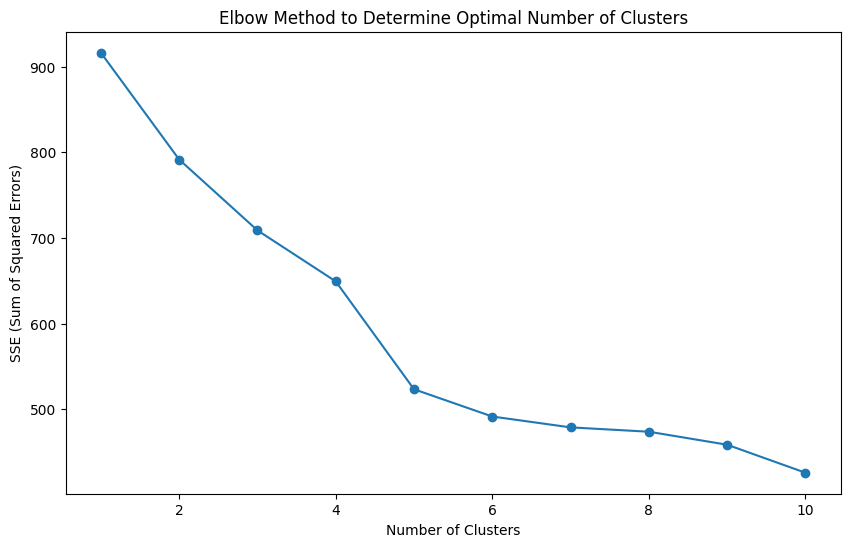

<Figure size 640x480 with 0 Axes>

In [36]:
# Find out optimal cluster number
kmeans_clustering_elbow(df_clustering) # Let's use 5 clusters

In [37]:
cluster_labels=kmeans_clustering(df_clustering,clusters=5)

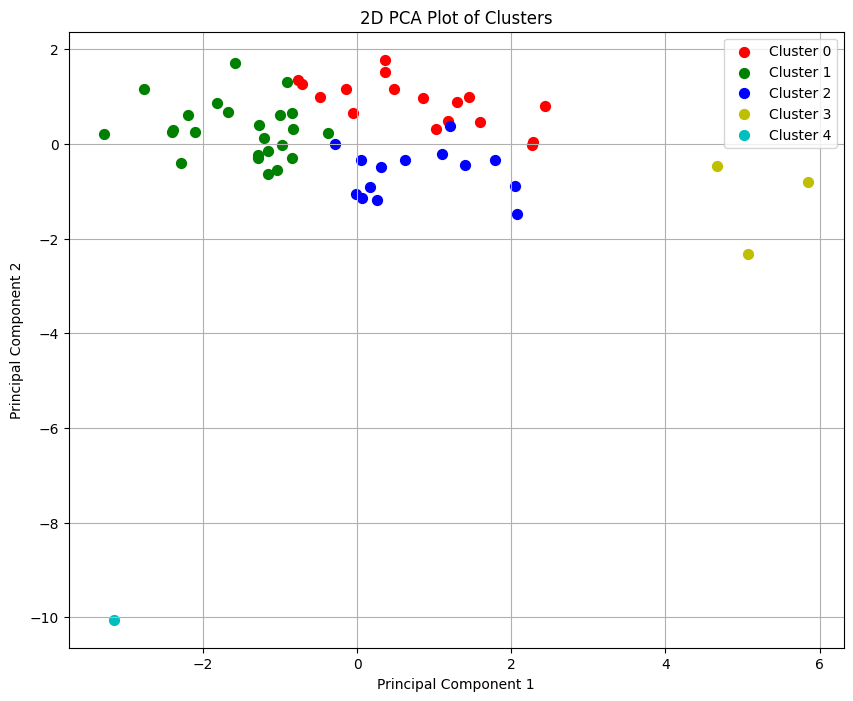

<Figure size 640x480 with 0 Axes>

In [38]:
# Plotting clusters using PCA
plot_clusters(df_clustering,cluster_labels)

In [39]:
# Attach cluster labels to original df
cluster_segments=analyze_clusters(df_customers.copy(), cluster_labels)

In [40]:
cluster_segments

,tracks_purchased,total_spent,transactions_per_customer,total_tracks_purchased,total_spent_per_customer,average_spend,days_active,purchase_frequency,recency,country,city,state,company,media_type,genre,composer,album_title,artist_name,favorite_genre
Cluster,,,,,,,,,,,,,,,,,,,
0,38.0,38.561176,27.529412,38.0,38.561176,1.412382,1644.647059,0.016754,93.058824,Canada,Amsterdam,AB,Riotur,MPEG audio file,Rock,Kurt Cobain,...And Justice For All,Iron Maiden,Rock
1,38.0,37.995000,29.916667,38.0,37.995000,1.276087,1294.000000,0.023171,271.416667,Canada,Berlin,CA,Apple Inc.,MPEG audio file,Rock,Steve Harris,Beyond Good And Evil,Iron Maiden,Rock
2,38.0,41.548571,27.071429,38.0,41.548571,1.539854,1292.071429,0.020965,273.571429,USA,Budapest,CA,Embraer - Empresa Brasileira de Aeronáutica S.A.,MPEG audio file,Rock,Adrian Smith,My Way: The Best Of Frank Sinatra [Disc 1],Led Zeppelin,Rock
3,38.0,47.620000,24.000000,38.0,47.620000,2.003442,1522.000000,0.015991,126.000000,Czech Republic,Dublin,Dublin,N/A,MPEG audio file,Rock,U2,A-Sides,Caetano Veloso,Rock
4,36.0,36.640000,25.000000,36.0,36.640000,1.465600,1151.000000,0.021701,581.000000,India,Bangalore,N/A,N/A,MPEG audio file,Rock,Miles Davis,Sex Machine,James Brown,Rock


#### Predictive Customer Lifetime Value (CLV)

In [41]:
df_clv=df_customers.copy()
df_clv['Clusters']=cluster_labels
df_clv.drop(['total_spent_per_customer','average_spend'],axis=1,inplace=True) # we remove these features as it would be massive leaking

In [42]:
df_clv,model,X=predict_total_spent(df_clv)

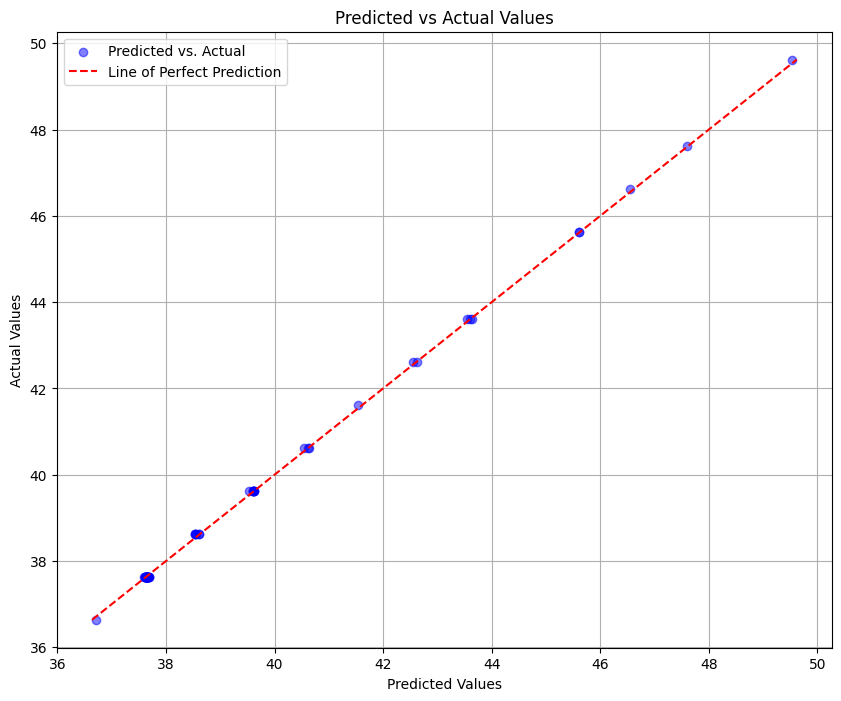

<Figure size 640x480 with 0 Axes>

In [43]:
plot_predicted_vs_actual(df_clv['total_spent'],df_clv['predicted_total_spent'])

#### SHAP

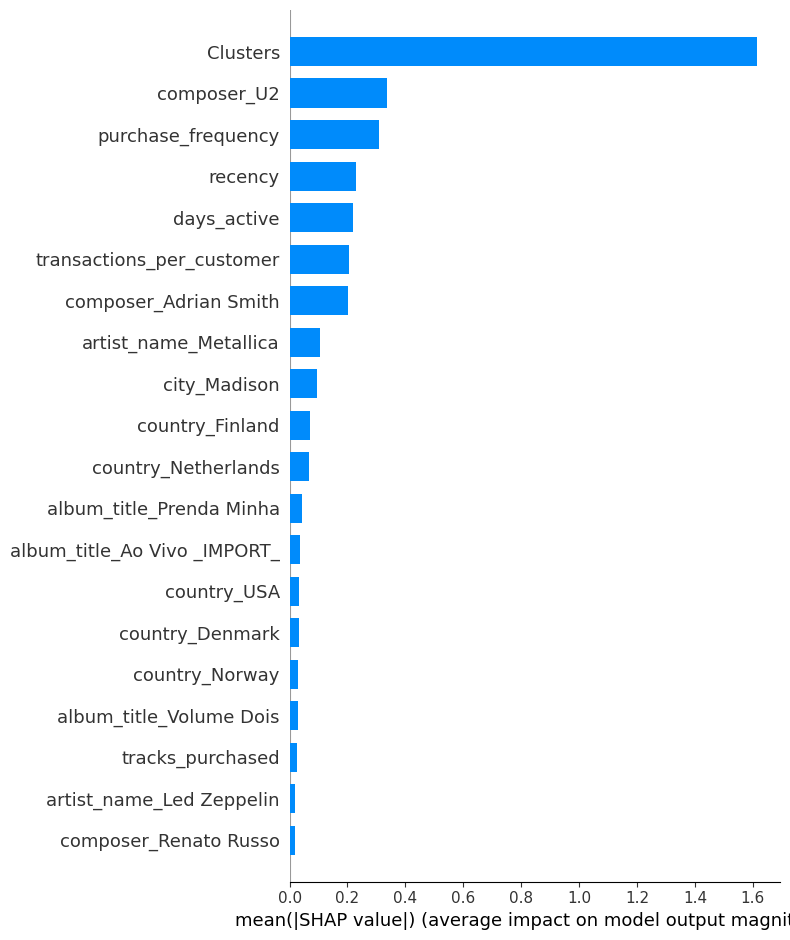

<Figure size 640x480 with 0 Axes>

In [44]:
plot_shap_absmean(model,X)